<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/Image_high_resolution_reconstruction_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
from keras.layers import Layer # Import the Layer class for custom layers
from keras.utils import register_keras_serializable # Import the decorator for registering custom objects
from keras.models import load_model # Import the load_model function

import os
import math
import numpy as np

from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
root_dir = "/content/drive/MyDrive/Datasets/BSDS500/images/"


#Create training and validation datasets via image_dataset_from_directory.

In [30]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    f"{root_dir}/training",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,  # No labels expected
)

valid_ds = image_dataset_from_directory(
    f"{root_dir}/validation",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,  # No labels expected
)

test_ds = image_dataset_from_directory(
    f"{root_dir}/test",
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    label_mode=None,  # No labels expected
)


Found 200 files.
Using 160 files for training.
Found 100 files.
Using 20 files for validation.
Found 200 files.


In [31]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

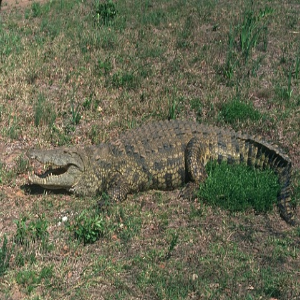

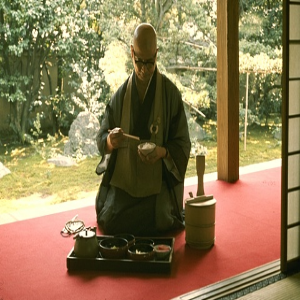

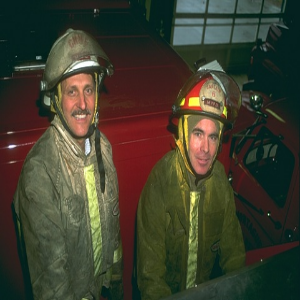

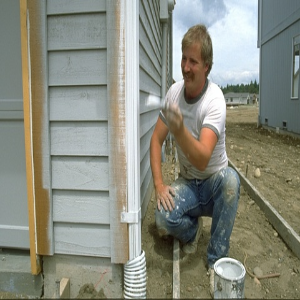

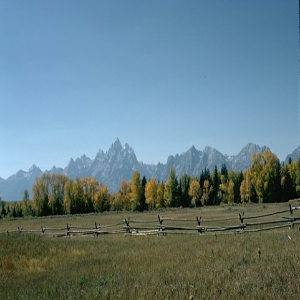

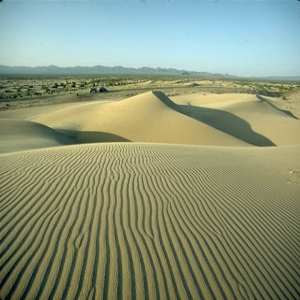

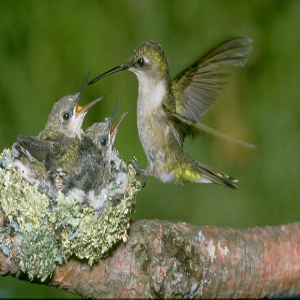

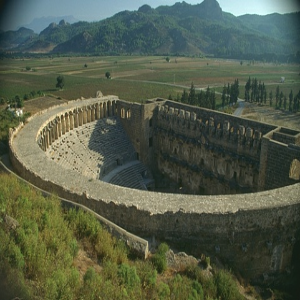

In [32]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

#Prepare a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [33]:
test_path= os.path.join(root_dir, "test")


test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

#Crop and resize images

In [34]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

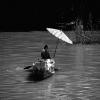

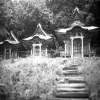

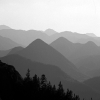

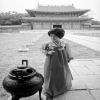

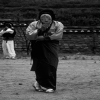

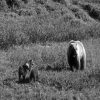

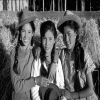

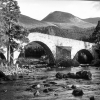

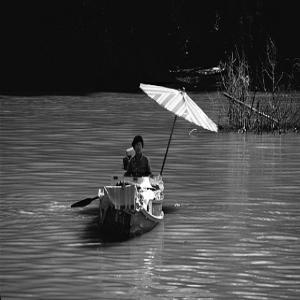

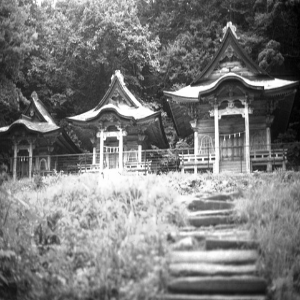

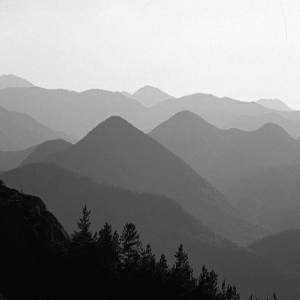

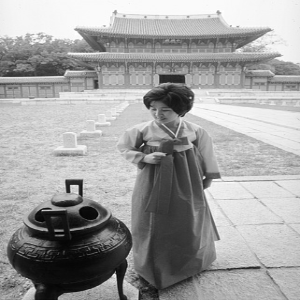

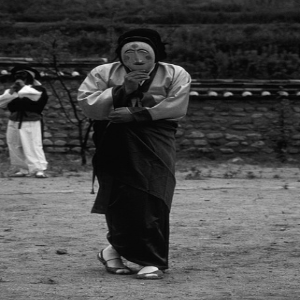

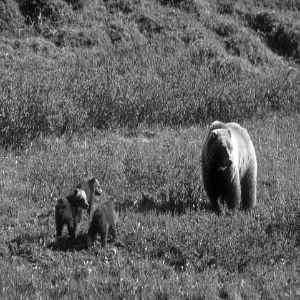

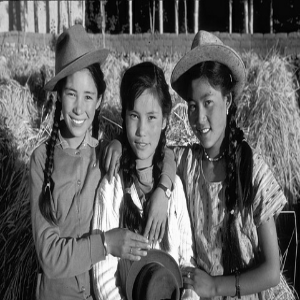

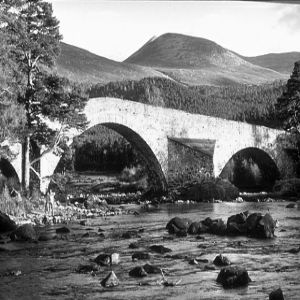

In [35]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

#Build the model

In [48]:
from tensorflow import keras
from tensorflow.keras import layers

def depth_to_space(x, block_size):
    return tf.nn.depth_to_space(x, block_size=block_size)

def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": None,  # We apply activation separately after BatchNorm
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }

    inputs = keras.Input(shape=(None, None, channels))

    # First convolutional layer
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second convolutional layer
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Third convolutional layer
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Residual Connection
    residual = layers.Conv2D(32, 3, **conv_args)(inputs)  # Match channels to 32
    residual = layers.BatchNormalization()(residual)

    # Add residual connection
    x = layers.Add()([x, residual])

    # Final convolution to match the upscale factor
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)

    # Pixel shuffling for upscaling
    outputs = layers.Lambda(depth_to_space, arguments={'block_size': upscale_factor})(x)

    return keras.Model(inputs, outputs)


#Define utility functions

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

#Define callbacks to monitor training

In [37]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [49]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, None, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, None, None, 64) │          1,664 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, None, None, 64) │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_24             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, None, None, 64) │         36,928 │ activation_24[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, None, None, 64) │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_25             │ (None, None, None, 64) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, None, None, 32) │         18,464 │ activation_25[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, None, None, 32) │            128 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, None, None, 32) │            320 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_26             │ (None, None, None, 32) │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, None, None, 32) │            128 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, None, None, 32) │              0 │ activation_26[0][0],   │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, None, None, 9)  │          2,601 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, None, None, 1)  │              0 │ conv2d_41[0][0]        │
└──────────────────────

 Total params: 60,745 (237.29 KB)

 Trainable params: 60,361 (235.79 KB)

 Non-trainable params: 384 (1.50 KB)

#Train the model

Epoch 1/100
Mean PSNR for epoch: 10.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


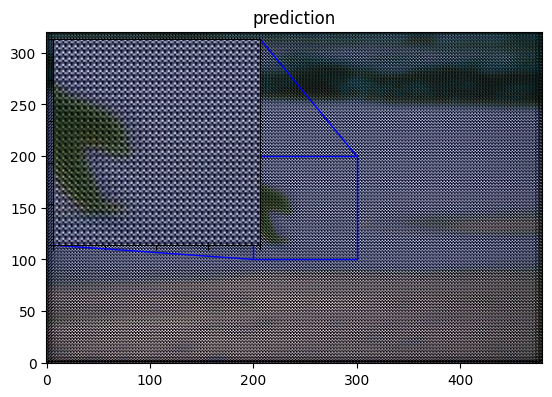

20/20 - 7s - 353ms/step - loss: 0.2994 - val_loss: 0.0958
Epoch 2/100
Mean PSNR for epoch: 11.02
20/20 - 2s - 122ms/step - loss: 0.0557 - val_loss: 0.0785
Epoch 3/100
Mean PSNR for epoch: 12.14
20/20 - 2s - 88ms/step - loss: 0.0313 - val_loss: 0.0672
Epoch 4/100
Mean PSNR for epoch: 12.34
20/20 - 1s - 51ms/step - loss: 0.0217 - val_loss: 0.0611
Epoch 5/100
Mean PSNR for epoch: 13.58
20/20 - 1s - 51ms/step - loss: 0.0192 - val_loss: 0.0448
Epoch 6/100
Mean PSNR for epoch: 14.63
20/20 - 1s - 61ms/step - loss: 0.0167 - val_loss: 0.0347
Epoch 7/100
Mean PSNR for epoch: 14.25
20/20 - 1s - 50ms/step - loss: 0.0146 - val_loss: 0.0371
Epoch 8/100
Mean PSNR for epoch: 14.77
20/20 - 1s - 64ms/step - loss: 0.0146 - val_loss: 0.0350
Epoch 9/100
Mean PSNR for epoch: 14.47
20/20 - 1s - 64ms/step - loss: 0.0123 - val_loss: 0.0364
Epoch 10/100
Mean PSNR for epoch: 14.72
20/20 - 1s - 63ms/step - loss: 0.0102 - val_loss: 0.0326
Epoch 11/100
Mean PSNR for epoch: 13.87
20/20 - 2s - 84ms/step - loss: 0.011

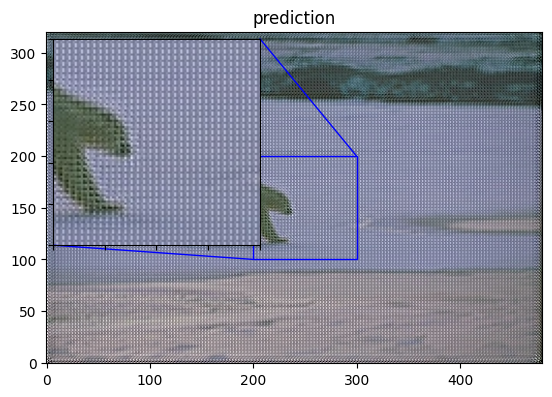

20/20 - 2s - 101ms/step - loss: 0.0074 - val_loss: 0.0205
Epoch 22/100
Mean PSNR for epoch: 15.65
20/20 - 2s - 90ms/step - loss: 0.0078 - val_loss: 0.0251
Epoch 23/100
Mean PSNR for epoch: 18.63
20/20 - 2s - 83ms/step - loss: 0.0073 - val_loss: 0.0145
Epoch 24/100
Mean PSNR for epoch: 18.91
20/20 - 1s - 50ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 25/100
Mean PSNR for epoch: 18.89
20/20 - 1s - 66ms/step - loss: 0.0069 - val_loss: 0.0131
Epoch 26/100
Mean PSNR for epoch: 17.66
20/20 - 1s - 52ms/step - loss: 0.0077 - val_loss: 0.0168
Epoch 27/100
Mean PSNR for epoch: 19.37
20/20 - 1s - 59ms/step - loss: 0.0100 - val_loss: 0.0124
Epoch 28/100
Mean PSNR for epoch: 22.08
20/20 - 1s - 49ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 29/100
Mean PSNR for epoch: 20.08
20/20 - 1s - 52ms/step - loss: 0.0058 - val_loss: 0.0096
Epoch 30/100
Mean PSNR for epoch: 20.53
20/20 - 1s - 48ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 31/100
Mean PSNR for epoch: 21.28
20/20 - 1s - 62ms/step - loss

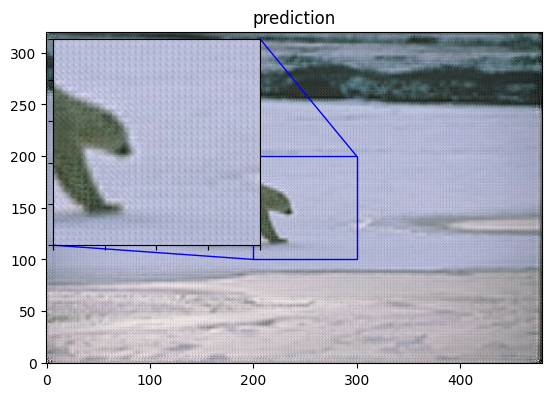

20/20 - 2s - 98ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 42/100
Mean PSNR for epoch: 20.91
20/20 - 3s - 131ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 43/100
Mean PSNR for epoch: 22.73
20/20 - 2s - 90ms/step - loss: 0.0078 - val_loss: 0.0052
Epoch 44/100
Mean PSNR for epoch: 22.05
20/20 - 1s - 63ms/step - loss: 0.0101 - val_loss: 0.0067


In [50]:
epochs = 100

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
PSNR of low resolution image and high resolution image is 30.0157
PSNR of predict and high resolution is 22.2483


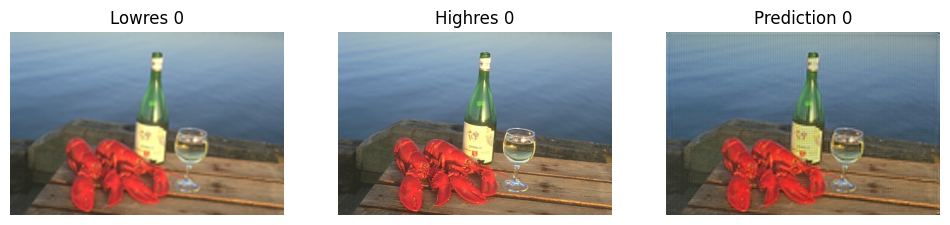

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
PSNR of low resolution image and high resolution image is 25.1103
PSNR of predict and high resolution is 17.7114


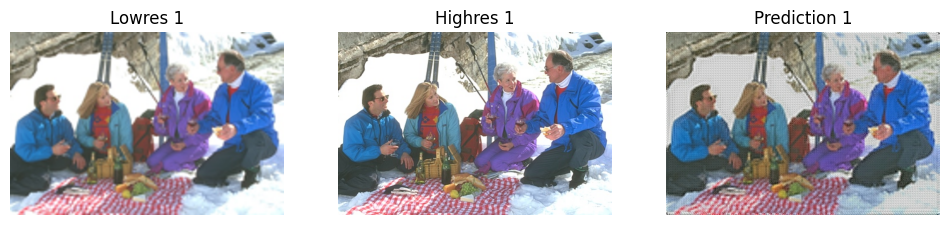

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
PSNR of low resolution image and high resolution image is 27.7789
PSNR of predict and high resolution is 19.7856


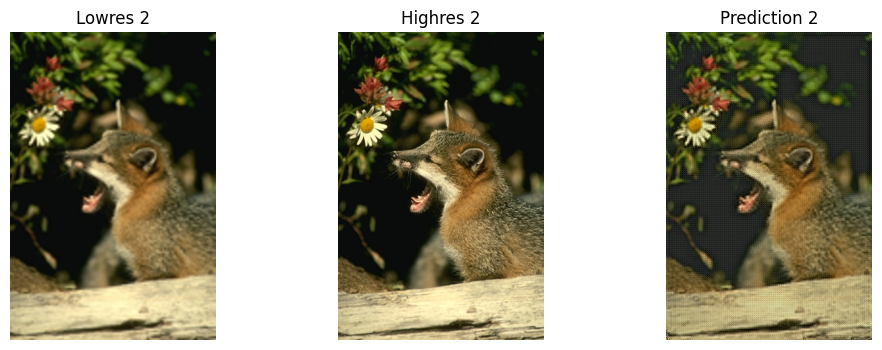

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PSNR of low resolution image and high resolution image is 28.0321
PSNR of predict and high resolution is 23.8244


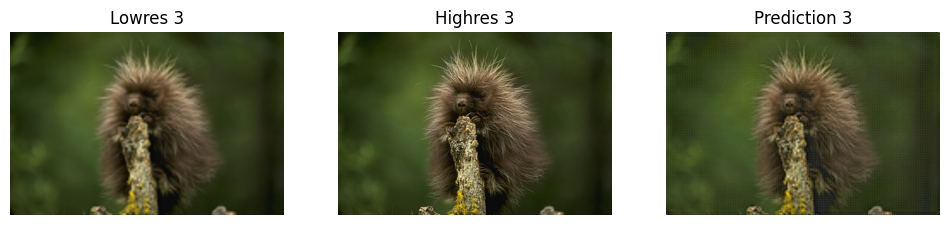

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
PSNR of low resolution image and high resolution image is 25.7853
PSNR of predict and high resolution is 19.7357


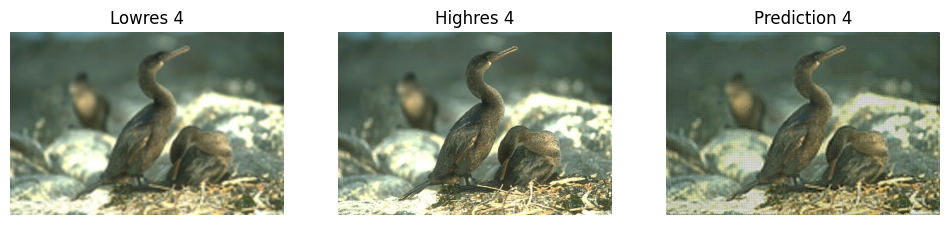

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
PSNR of low resolution image and high resolution image is 25.9181
PSNR of predict and high resolution is 20.8133


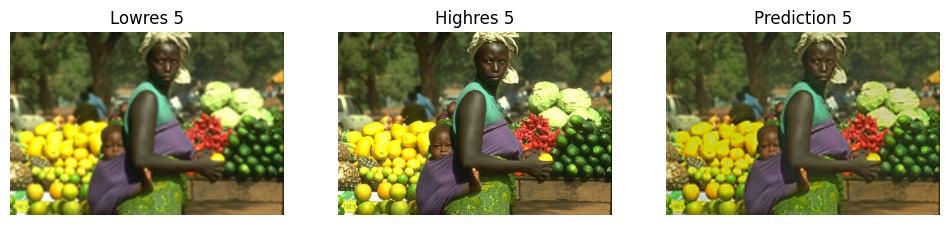

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
PSNR of low resolution image and high resolution image is 26.2389
PSNR of predict and high resolution is 21.7081


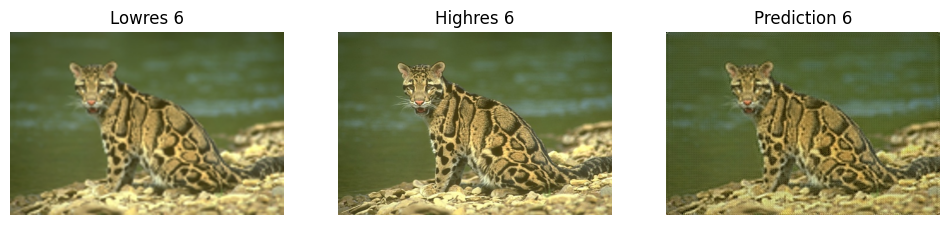

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
PSNR of low resolution image and high resolution image is 23.3281
PSNR of predict and high resolution is 21.4648


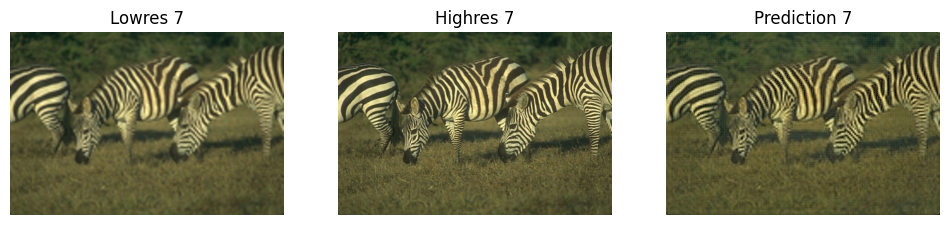

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
PSNR of low resolution image and high resolution image is 29.9008
PSNR of predict and high resolution is 26.1592


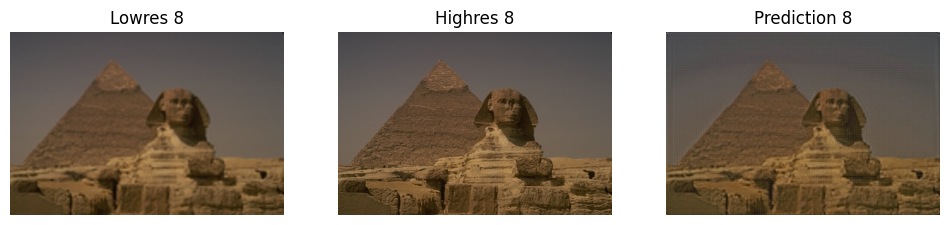

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
PSNR of low resolution image and high resolution image is 25.2492
PSNR of predict and high resolution is 19.8041


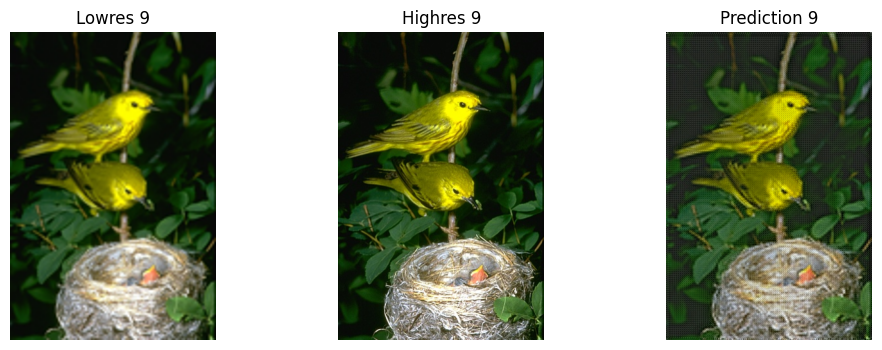

Avg. PSNR of lowres images is 26.7357
Avg. PSNR of reconstructions is 21.3255


In [51]:
import matplotlib.pyplot as plt

total_bicubic_psnr = 0.0
total_test_psnr = 0.0

def plot_side_by_side(lowres_img, highres_img, prediction, index):
    plt.figure(figsize=(12, 4))

    # Plot Lowres Image
    plt.subplot(1, 3, 1)
    plt.imshow(lowres_img)
    plt.title(f'Lowres {index}')
    plt.axis('off')

    # Plot Prediction Image
    plt.subplot(1, 3, 3)
    plt.imshow(prediction)
    plt.title(f'Prediction {index}')
    plt.axis('off')

    # Plot Highres Image
    plt.subplot(1, 3, 2)
    plt.imshow(highres_img)
    plt.title(f'Highres {index}')
    plt.axis('off')



    # Show the plot
    plt.show()

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)

    # Display images side by side
    plot_side_by_side(lowres_img, highres_img, prediction, index)

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [52]:
save_dir_drive = '/content/drive/MyDrive/Models/ImgHighRes'
os.makedirs(save_dir_drive, exist_ok=True)  # Ensure the directory exists

save_path = os.path.join(save_dir_drive, 'image_high_resolution_reconstruction2.keras')
model.save(save_path)
print(f"Model saved successfully at {save_path}")

Model saved successfully at /content/drive/MyDrive/Models/ImgHighRes/image_high_resolution_reconstruction2.keras


In [53]:
# Provide the custom function when loading the model
load_model = tf.keras.models.load_model(save_path, custom_objects={'depth_to_space': depth_to_space})
print("Model loaded successfully.")

Model loaded successfully.
